<a href="https://colab.research.google.com/github/andygoosh/OneTwoTrip-Contest/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import sklearn
if '0.22' != sklearn.__version__:
  !pip install -U scikit-learn
  import os
  os.kill(os.getpid(), 9)

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#%load_ext tensorboard

%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

import random as rn
import pandas as pd
import xarray
import requests
import datetime
import numpy as np
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import sklearn as skl
import seaborn as sns
import xgboost as xgb
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

import tensorflow as tf
import tensorflow.keras as keras

print(tf.test.gpu_device_name())
print(tf.__version__)
print(keras.__version__)
print(sklearn.__version__)
assert ('0.22' == sklearn.__version__)

from keras import layers
from keras.callbacks import TensorBoard
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import sklearn.ensemble

import warnings
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.6f}'.format

RS = 77
rn.seed(RS)
tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)

df_train = pd.read_csv('https://boosters.pro/api/ch/files/pub/onetwotrip_challenge_train.csv', index_col='orderid', dtype={'field1': np.float32, 'field14': np.float32})
df_test = pd.read_csv('https://boosters.pro/api/ch/files/pub/onetwotrip_challenge_test.csv', index_col='orderid', dtype={'field1': np.float32, 'field14': np.float32})

df_train.head()

Populating the interactive namespace from numpy and matplotlib
/device:GPU:0
2.0.0
2.2.4-tf
0.22


,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1
orderid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,10d654494cbe97bbb25d51ead2600679aff9e097924add...,0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661308,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1,0,1,0,0,0,0
1,4aafc0391f72bbcf60537aece62923baf9ce644b64ac36...,144,-0.393794,5,7,2,0,0,2,1,0,0,21,125,3,-0.101043,1,57,1,5,1,6,2,121,15,1,41,3,1,0,2,1,1,0,1,0,0,0,0,0,0,0
2,bac8ffef46348f587c8d17137ab01fb24aef21547c647d...,134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661308,1,4,1,2,3,6,2,17,14,1,1,11,7,0,1,1,1,0,1,1,0,0,0,0,0,0
3,0392247b4b87674aba2c32bf2292b105771a6a376871be...,0,-0.238651,10,11,1,1,3,2,1,0,0,19,12,3,-0.521242,2,22,1,3,3,4,1,46,12,2,18,1,1,0,4,1,1,0,1,1,0,0,0,0,0,0
4,d1aeefef311bbeb4bd84876c8d49421f276674527d5578...,0,-0.704080,8,11,1,1,0,1,1,0,1,16,4,3,-0.801375,1,100,1,6,1,1,1,17,22,1,1,1,1,0,3,1,1,0,0,1,0,0,0,0,0,0


In [2]:
df_train.describe()

,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1
count,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000
mean,28.413163,0.000912,7.980363,7.867864,3.528966,0.556214,1.577911,1.265292,0.879366,0.023937,0.448117,14.633431,12.010492,27.046028,0.001822,1.517153,15.723854,3.001301,3.811941,2.076172,3.993762,1.226471,38.751938,13.028186,1.404645,4.923456,3.875780,1.746557,0.088572,2.980837,0.994966,0.979649,0.348676,0.645754,0.647687,0.036627,0.168579,0.038713,0.022519,0.015098,0.022142
std,69.603944,1.009402,2.757008,3.013659,12.692057,0.496831,5.614900,0.441489,0.325702,0.164366,0.497302,5.519693,19.579464,55.490962,1.007440,0.952774,25.689926,8.510708,1.931365,0.980940,1.975246,0.418548,71.517212,6.132370,0.784647,11.652149,4.230396,1.376456,0.369773,0.919229,0.070774,0.141199,0.476552,0.478285,0.477692,0.187845,0.374381,0.192912,0.148365,0.121942,0.147144
min,0.000000,-0.859222,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-0.941441,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-0.471365,6.000000,6.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,11.000000,4.000000,3.000000,-0.521242,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-0.238651,8.000000,8.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,15.000000,5.000000,4.000000,-0.241109,1.000000,6.000000,1.000000,4.000000,2.000000,4.000000,1.000000,17.000000,13.000000,1.000000,1.000000,2.000000,1.000000,0.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13.000000,0.149205,10.000000,10.000000,2.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,19.000000,11.000000,26.000000,0.179090,2.000000,18.000000,1.000000,5.000000,3.000000,6.000000,1.000000,42.000000,18.000000,2.000000,1.000000,5.000000,3.000000,0.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,500.000000,82.142136,12.000000,12.000000,363.000000,1.000000,323.000000,2.000000,1.000000,4.000000,1.000000,23.000000,273.000000,746.000000,55.225182,18.000000,340.000000,156.000000,7.000000,8.000000,7.000000,2.000000,867.000000,23.000000,18.000000,170.000000,28.000000,7.000000,8.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


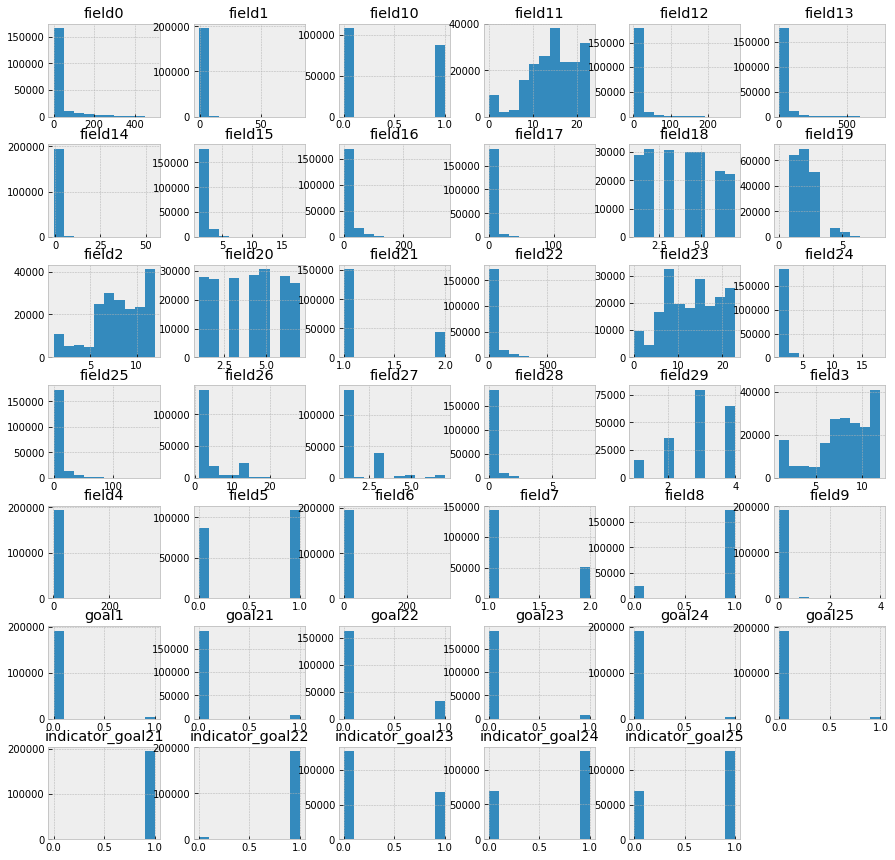

In [0]:
fig, ax = plt.subplots(figsize=(15,15))
df_train.hist(ax=ax);

In [0]:
import seaborn as sns
sns.boxplot(x=X['14/4'])

In [0]:
df_train['field6'].quantile(0.99)

21.0

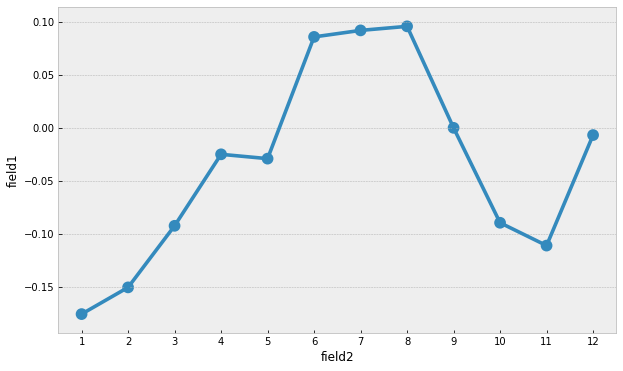

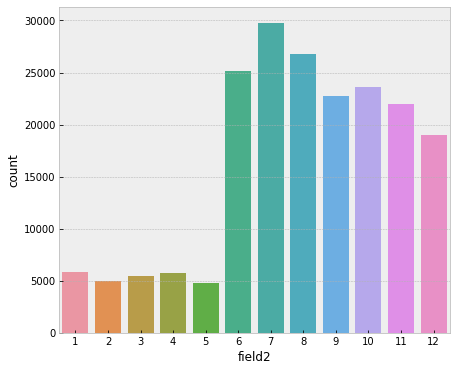

In [0]:
X = df_train

df11 = X.groupby(['field2'])[['field1']].mean()
df11.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(10, 6))
sns.pointplot(x='field2', y='field1', data=df11, ax=ax);

fig, ax = plt.subplots(figsize=(7, 6))
sns.countplot(X['field2'], ax=ax);
#sns.scatterplot(x='field11', y='field1', data=X, alpha=0.8, ax=ax);

In [0]:
df_train.describe()
df_test.describe()
full = pd.concat([df_train, df_test])
full.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,field0,field1,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field2,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,field3,field4,field5,field6,field7,field8,field9,goal1,goal21,goal22,goal23,goal24,goal25,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25
count,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,196056.000000,651067.000000,651067.000000,651067.000000,651067.000000,651067.000000
mean,28.415045,-0.000000,0.447739,14.616669,11.989201,27.305330,0.000000,1.518057,15.631981,2.993680,3.808444,2.075998,7.978630,3.989258,1.226731,39.004728,13.045100,1.406829,4.878449,3.899232,1.751784,0.087546,2.980225,7.867928,3.747118,0.556672,1.577236,1.263658,0.879828,0.023683,0.022142,0.036627,0.168579,0.038713,0.022519,0.015098,0.994985,0.979761,0.348374,0.645238,0.647944
std,69.704182,1.000198,0.497262,5.525271,19.690783,58.136270,0.999930,0.965593,25.436819,8.508684,1.932545,0.978270,2.754209,1.976828,0.418717,73.999480,6.132659,0.798080,11.625625,4.254252,1.379756,0.369092,0.919228,3.010155,18.094611,0.496778,5.573744,0.440616,0.325163,0.163779,0.147144,0.187845,0.374381,0.192912,0.148365,0.121942,0.070638,0.140817,0.476456,0.478442,0.477612
min,0.000000,-0.859222,0.000000,0.000000,1.000000,0.000000,-0.941441,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-0.471365,0.000000,11.000000,4.000000,3.000000,-0.521242,1.000000,2.000000,1.000000,2.000000,1.000000,6.000000,2.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,6.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,-0.238651,0.000000,15.000000,5.000000,4.000000,-0.241109,1.000000,6.000000,1.000000,4.000000,2.000000,8.000000,4.000000,1.000000,17.000000,13.000000,1.000000,1.000000,2.000000,1.000000,0.000000,3.000000,8.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,13.000000,0.149205,1.000000,19.000000,11.000000,26.000000,0.179090,2.000000,18.000000,1.000000,5.000000,3.000000,10.000000,6.000000,1.000000,42.000000,18.000000,2.000000,1.000000,5.000000,3.000000,0.000000,4.000000,10.000000,2.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,507.000000,82.142136,1.000000,23.000000,316.000000,928.000000,55.225182,18.000000,340.000000,179.000000,7.000000,9.000000,12.000000,7.000000,2.000000,1049.000000,23.000000,18.000000,193.000000,30.000000,7.000000,16.000000,4.000000,12.000000,756.000000,1.000000,344.000000,2.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
data_mean, data_std = df_train.field9.mean(), df_train.field9.std()
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

outliers = [x for x in df_train.field9 if x < lower or x > upper]
len(outliers), len(df_train.field4)

(4350, 196056)

In [0]:
a = df_train.groupby('userid', as_index=False).count()
a = a[a.field0 > 1]
a.field0.max()


363

In [0]:
def vectorize( X, cols ):

  for col in cols:
    df = pd.get_dummies(X[col])
    df.columns = ['%s_%d' % (col, i) for i in range(df.shape[1])]
    X = X.join(df)
  X.drop(cols, axis=1, inplace=True)

  return X

def undersample_data(X):
    # Separate majority and minority classes
    df_majority = X[X['goal1']==0]
    df_minority = X[X['goal1']==1]
    
    n_samples = math.floor( X['goal1'].sum() * undersample )

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                    replace=False,    # sample without replacement
                                    n_samples=n_samples,     # to match minority class
                                    random_state=RS) # reproducible results
    
    # Combine minority class with downsampled majority class
    X = pd.concat([df_majority_downsampled, df_minority])# Separate majority and minority classes

    return X

In [0]:
def remove_outliers( X, y ):
  # remove the outlier rows
  X = X[X.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
  # remove the columns with equal values
  X = X.loc[:,X.apply(pd.Series.nunique) != 1]
  # fix the target index
  y = y[y.index.isin(X.index)]

  return X, y

def mark_outliers( X, outlier_ratio=0 ):
  outlier_index = X.apply(lambda x: np.abs(x - x.mean()) / x.std() < outlier_ratio).all(axis=1)
  X['otl'] = 1
  X.loc[outlier_index, 'otl'] = 0
  return X

def prepare_data( data, outlier_ratio=0):
  # filed4 - order count
  # field15 - это все билеты. Эти билеты делятся на три категории.
  # field24 - билеты взрослого человека. Их количество от 1 до 18 (есть три билета с нулем, что может быть шумом).
  # field28 - билеты ребенка от 2 до 6 лет. В основном таких билетов нет. Максимум 16. Все логично, всегда должен быть 1 взрослый. На него уходит 2 билета (если брать максимальный случай).
  # field9 - билеты ребенка до года. На сайте можно взять максимум 4 таких билета, на каждого из них нужен +1 взрослый.
  X = data.copy()
  y = []

  # separate the target goosh
  if  'goal1' in X.columns:
    y = X[['goal1']].astype(int)
    #y += 1

  FTS = list(filter(lambda x: 'field' in x, X.columns))
  X = X[FTS]

  if outlier_ratio > 0:
    X = mark_outliers(X, outlier_ratio)

  #X, y = remove_outliers(X, y)

  '''
  # add polimonial
  X['field7_field16'] = X['field7'] * X['field16']
  X['field16_field17'] = X['field16'] * X['field17']
  #X['field16_field25'] = X['field16'] * X['field25']
  X['field12_field16'] = X['field12'] * X['field16']
  X['field7_field12'] = X['field7'] * X['field12']
  X['field12_field25'] = X['field12'] * X['field25']
  '''

  #Anti-StandardScaler для Field1 и Field14 тиснуто отсюда https://github.com/IlyaSviridov/OneTwoTrip-Contest/blob/master/EDA_fields.ipynb
  unique14 = np.unique(X['field14'])
  new_unique14 = np.round(unique14 / 0.14006639 - 0.27860731).astype(int)
  dict14 = {unique14[i]: new_unique14[i] for i in range(len(unique14))}
  X['field14'] = X['field14'].apply(lambda x: dict14[x])

  unique1 = np.unique(X['field1'])
  new_unique1 = np.round(unique1  / 0.077571 + 0.0765905).astype(int)
  dict1 = {unique1[i]: new_unique1[i] for i in range(len(unique1))}
  X['field1'] = X['field1'].apply(lambda x: dict1[x])

  # This slightly improves auc
  #X['field10'] = X['field10'] + 1

  '''
  cols_to_vec = []
  for e in X.columns:
    uniques = X[e].nunique()
    if (uniques > 2) & (uniques < 30):
      cols_to_vec.append(e)
  X = vectorize(X, cols_to_vec)
  '''

  #X['14/1'] = X['field14'] / X['field1']
  #X.drop(['field1', 'field14',], axis=1, inplace=True)

  #corr.field2['field29'], corr.field15['field24']

  #X = vectorize(X, ['field21']) #, 'field5', 'field7', 'field8', 'field9', 'field10', 'field18', 'field19', 'field20', 'field27'])
  #X.drop(['field12', 'field16'], axis=1, inplace=True)
  
  #X['userid'] = data['userid']

  return X, y

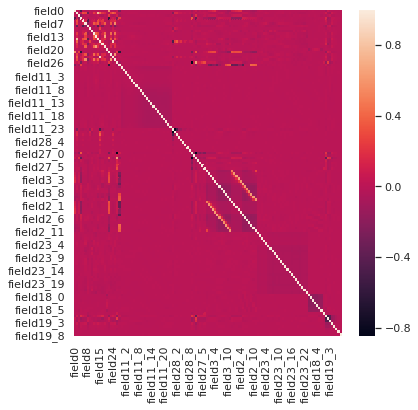

In [0]:
import seaborn as sns; sns.set()
#X, y = prepare_data(df_train)
ax = sns.heatmap(X.corr())

In [0]:
X.corr().nlargest(10)

In [0]:
corr = df_train.corr()
corr.field2['field29'], corr.field15['field24']

(0.9539990460663368, 0.8997383624774794)

In [0]:
def add_polynomial_inner( X, poly ):
  X = X
  X = pd.DataFrame(poly.transform(X), index=X.index, columns = poly.get_feature_names(X.columns))
  return X
    
def add_polynomial(X_train, X_cv=None, degree=2):
  poly = sklearn.preprocessing.PolynomialFeatures(degree)
  poly.fit(X)
  
  X_train = add_polynomial_inner(X_train, poly)
  if X_cv is not None:
      X_cv = add_polynomial_inner(X_cv, poly)

  #poly_corrs = poly_features.corrwith(y).sort_values(ascending=False)
  #poly_corrs = poly_features.corrwith(y).nlargest(20)

  return X_train, X_cv, poly

  def add_neughbors_inner( X, neigh ):
    X = X.copy()
    dists, _ = neigh.kneighbors(X, return_distance=True)
    X['K-mean'] = dists.mean(axis=1).reshape(-1, 1)
    X['K-max'] = dists.max(axis=1).reshape(-1, 1)
    return X

def add_neighbors(X_train, X_cv=None, n_neighbors=5):
  neigh = skl.neighbors.NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
  neigh.fit(X_train)

  X_train = add_neughbors_inner(X_train, neigh)
  if X_cv is not None:
      X_cv = add_neughbors_inner(X_cv, neigh)

  return X_train, X_cv, neigh

In [0]:
def fit_estimate( X, y, model_generator, n_folds = 5, n_neighbors=0, degree=0):

  scores = []
  models = []
  neighbs = []
  polies = []

  folds = list(skl.model_selection.StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS).split(X, y))
  for j, (train_idx, val_idx) in enumerate(folds):

    X_train, X_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_cv = y.iloc[train_idx], y.iloc[val_idx]

    if degree > 1:
      X_train, X_cv, poly = add_polynomial(X_train, X_cv, degree)
      polies.append(poly)
    
    if n_neighbors > 0:
      X_train, X_cv, neigh = add_neighbors(X_train, X_cv, n_neighbors)
      neighbs.append(neigh)

    model = model_generator()
    model.fit(X_train, y_train.values.ravel(), 
              eval_set=[(X_cv, y_cv.values.ravel())],
              early_stopping_rounds=100,
              verbose=False
              )
    plot_cm_and_roc(model, X_cv, y_cv, 'cv')

    y_pred_cv = model.predict_proba(X_cv)
    # score = skl.metrics.roc_auc_score(keras.utils.to_categorical(y_cv), y_pred_cv) # works for multiclass
    score = skl.metrics.roc_auc_score(y_cv, y_pred_cv[:, 1]) # better one for binary
    scores.append(score)
    models.append(model)
    #print('[{:}/{:}>{:.5f}]'.format(j+1,n_folds, score) , end='')

  print('{:} cv: {:.4f} ± {:.4f}.'.format(type(model).__name__, np.mean(scores), np.std(scores)))
  return scores, models, neighbs, polies

In [0]:
def plot_permutation_importance(model, X_test, y_test, X_cv=None, y_cv=None):
  result = permutation_importance(model, X_test, y_test.values.ravel(), n_repeats=10, random_state=RS)
  sorted_idx = result.importances_mean.argsort()

  if  X_cv is None:
    fig, ax = plt.subplots(figsize=(15,5))
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title("Permutation Importance of each feature")
    ax.set_ylabel("Features")
    fig.tight_layout()
  else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
    ax1.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    ax1.set_title("Test Permutation Importance of each feature")
    ax1.set_ylabel("Features")

    result = permutation_importance(model, X_cv, y_cv.values.ravel(), n_repeats=10, random_state=RS)
    sorted_idx = result.importances_mean.argsort()

    ax2.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    ax2.set_title("CV Permutation Importance of each feature")
    ax2.set_ylabel("Features")

    fig.tight_layout()

  plt.show()

def plot_cm_and_roc(model, X, y, title=''):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
  fig.patch.set_facecolor((1.0, 1.0, 1.0))
  fig.suptitle('{} {}'.format(type(model).__name__, title))
  skl.metrics.plot_confusion_matrix(model, X, y, ax=ax1)
  skl.metrics.plot_roc_curve(model, X, y, ax=ax2)

  plt.show()

In [87]:
def add_aggregates(X, aggs=[], cols=[]):

  if len(aggs) == 0:
    aggs = ['std', 'sum', 'max', 'min', 'mean', 'count']

  if len(cols) == 0:
    cols = list(filter(lambda x: 'field' in x, X.columns))

  # add aggregates for userid
  grouped_by = X.groupby('userid')
  all_features = []
  
  # add count
  if 'count' in aggs:
    grouped = grouped_by.agg({'userid': 'count'})
    grouped.columns = ['count']
    all_features.append( grouped )
    aggs.remove('count')
  
  for col in cols:
    grouped = grouped_by.agg({col: aggs}) 
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    all_features.append(grouped)

  if len(all_features)>0:
    all_features = pd.concat(all_features, axis=1)
    X = X.merge(all_features, on=('userid'))

  X.fillna(0, inplace=True)

  return X.drop(['userid'], axis=1)

def check_aggregates_result():
  a = df_train.groupby('userid', as_index=False).count()
  a = a[a.field0 == 5]
  a = df_train.loc[df_train.userid.isin([*a.userid])]
  #print(a.iloc[1].userid)
  a = a[a.userid == a.iloc[0].userid]

  return add_aggregates(a, cols=['field0'])
  
check_aggregates_result()

,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1,count,field0_std,field0_sum,field0_max,field0_min,field0_mean
0,23,-0.161080,9,9,5,0,0,2,1,0,1,13,18,12,0.179090,1,13,3,2,3,1,2,1,13,1,1,1,1,0,3,1,1,0,1,0,0,1,0,0,0,0,5,73.151897,286,175,0,57.200000
1,175,-0.548937,5,5,3,0,0,2,1,0,0,11,3,3,-0.521242,1,6,1,3,3,2,2,46,18,1,18,1,1,0,2,1,1,1,1,0,0,0,0,0,0,0,5,73.151897,286,175,0,57.200000
2,0,-0.471365,11,12,1,1,0,2,1,0,0,19,3,3,-0.381176,1,34,1,3,3,2,1,46,9,1,18,1,1,0,4,1,1,1,1,0,0,1,0,0,0,0,5,73.151897,286,175,0,57.200000
3,81,-0.161080,8,8,4,0,0,2,1,0,1,12,14,3,-0.521242,2,20,1,7,3,6,2,46,18,2,18,1,1,0,3,1,1,1,1,0,0,0,0,0,0,0,5,73.151897,286,175,0,57.200000
4,7,-0.393794,11,1,2,0,0,2,1,0,0,9,3,12,-0.381176,1,44,3,3,3,5,1,1,12,1,1,1,1,0,4,1,1,1,1,0,0,1,0,0,0,0,5,73.151897,286,175,0,57.200000


In [0]:
def to_buckets(X, bins):
  return pd.cut(X, 10, labels=False)


In [0]:
def estimate(X, y, model, plot=True):
  X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=RS, shuffle=True)
  
  # apply class weights
  class_weights = list(skl.utils.class_weight.compute_class_weight('balanced', np.unique(y_train), y_train.values.ravel()))
  w_array = pd.Series(np.ones(y_train.shape[0], dtype = 'float32'), index=y_train.index)\
                    .apply(lambda x: class_weights[0] if x==0 else class_weights[1])
  
  #try:
  #  sklearn.utils.validation.check_is_fitted(model, type(model).__name__, 'Model is not fitted')
  #except sklearn.utils.validation.NotFittedError:
  boosters = ['XGBClassifier', 'LGBMClassifier']
  if type(model).__name__ in boosters:
    print(0, end='')
    model.fit(X_train, y_train.values.ravel(), 
              eval_set=[(X_cv, y_cv.values.ravel())],
              early_stopping_rounds=200,
              verbose=False,
              #sample_weight=w_array
              )
  else:
    print(1, end='')
    model.fit(X_train, y_train.values.ravel(), 
              #sample_weight=w_array
              )

  if plot == True:
    plot_cm_and_roc(model, X_train, y_train, 'train')
    plot_cm_and_roc(model, X_cv, y_cv, 'cv')

  return model

In [0]:
print(skl.utils.class_weight.compute_class_weight('balanced', np.unique(y), y.values.ravel()))
counts = np.unique(y, return_counts=True)[1]
print(counts[0]/counts[1])

In [0]:
def get_best_params_xgbc():
  estimators = 298
  return {'base_score': 0.9883241431311958, 
  'booster': 'gbtree',
  'colsample_bylevel': 0.8954745282201794, 
  'colsample_bynode': 0.9053728787963939, 
  'colsample_bytree': 0.37737648074076036, 
  'gamma': 51, 
  'learning_rate': 0.06869149756603576, 
  'max_delta_step': 22, 
  'max_depth': 4, 
  'min_child_weight': 0.8940873051252118, 
  'missing': None,
  'n_estimators': estimators, 
  'n_jobs': -1,
  'nthread': None,
  'objective': 'binary:logistic',
  'random_state': RS,
  'reg_alpha': 0.2901487558842103, 
  'reg_lambda': 0.7240220329478356, 
  'scale_pos_weight': 0.11997115325466545,  #0.04082
  'seed': None,
  'silent': None,
  'subsample': 0.699092108437742,
  'verbosity': 0,
  # If there’s more than one metric in the eval_metric parameter given in params, the last metric will be used for early stopping
  'eval_metric': ['logloss', 'auc'],
  # 'rmse', 'rmsle', 'mae', 'logloss', 'error', 'error@t', 'merror', 'mlogloss', 'auc', 'aucpr', 'ndcg', 'map', 'ndcg@n', 'ndcg@n', 'ndcg-', 'map-', 'ndcg@n-', 'ndcg@n-'
  'tree_method': 'gpu_hist',
  'updater': 'grow_gpu_hist',
  'disable_default_eval_metric': 0,
  }

def get_best_params_lgbm():
    estimators = 203
    return {'boosting_type': 'gbdt',
            'class_weight': None,
            'colsample_bytree': 0.3811304824216669,
            'importance_type': 'split',
            'learning_rate': 0.016659893432998896,
            'max_depth': 20,
            'metric': ['logloss', 'auc'],
            'min_child_samples': 12,
            'min_child_weight': 0.0036350360157623163,
            'min_split_gain': 0.9619961904304549,
            'n_estimators': estimators,
            'n_jobs': -1,
            'num_leaves': 32,
            'objective': 'binary',
            'random_state': RS,
            'reg_alpha': 0.8022751137716411,
            'reg_lambda': 0.8186913351852023,
            'silent': True,
            'subsample': 0.5967826661188248,
            'subsample_for_bin': 200000,
            'subsample_freq': 14
            }


In [14]:

def check_agregates_score():
  AGGREGATES = ['count', 'std', 'sum', 'min', 'max', 'mean']

  FTS = list(filter(lambda x: 'field' in x, df_train.columns))
  scores = []
  attrs = []

  X_, y = prepare_data(df_train)
  model = estimate(X_, y, XGBClassifier(**get_best_params_xgbc()), plot=False)
  if hasattr(model, 'best_ntree_limit'): scores.append(model.best_score)
  if hasattr(model, 'best_score_'): scores.append(model.best_score_['valid_0']['auc'])
  attrs.append(('baseline', ))

  grouped_by = df_train.groupby('userid')
  for col in tqdm(FTS):
    for agg in AGGREGATES:
      X_ = add_aggregates(df_train, aggs=[agg], cols=[col])
      X_, y = prepare_data(X_)
      #model = estimate(X_, y, LGBMClassifier(**get_best_params_lgbm()), plot=False)
      model = estimate(X_, y, XGBClassifier(**get_best_params_xgbc()), plot=False)
      if hasattr(model, 'best_ntree_limit'): scores.append(model.best_score)
      if hasattr(model, 'best_score_'): scores.append(model.best_score_['valid_0']['auc'])
      attrs.append((agg, col))

  arr = np.array(scores)
  for i in arr.argsort()[-10:][::-1]:
    print(scores[i], attrs[i])

check_agregates_score()

0

000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
0.693892 ('baseline',)
0.691392 ('mean', 'field27')
0.690485 ('mean', 'field26')
0.690385 ('sum', 'field0')
0.689794 ('sum', 'field18')
0.689505 ('min', 'field16')
0.68933 ('std', 'field0')
0.689281 ('mean', 'field0')
0.689262 ('max', 'field0')
0.689157 ('sum', 'field26')


0

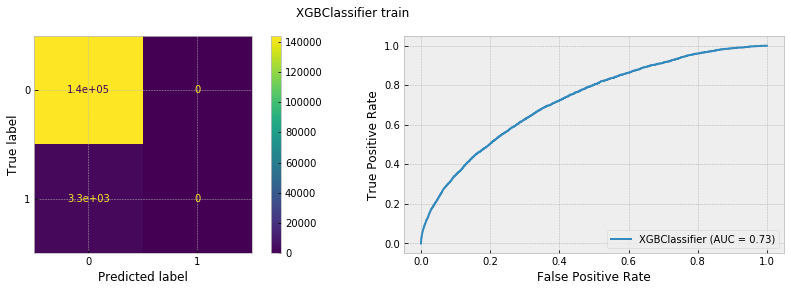

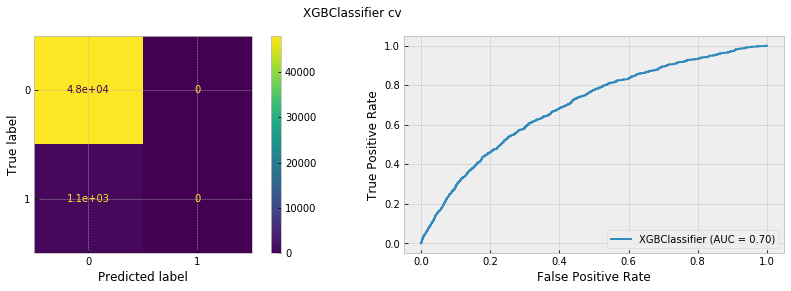

0.696557


In [103]:
#a = df_train.groupby('userid', as_index=False).count()
#a = a[a.field0 > 1]
#a = df_train.loc[df_train.userid.isin([*a.userid])]

X_ = df_train
X_ = X_.drop(['field5', 'field11', 'field23', 'field29'], axis=1) #0.696557
#X_ = X_.drop(['field9', 'field20'], axis=1)

#X_ = add_aggregates(X_)
X, y = prepare_data(X_)
       
#X, y = prepare_data(df_train)

#hgbc = skl.ensemble.HistGradientBoostingClassifier()
xgbc = XGBClassifier(**get_best_params_xgbc())
lgbm = LGBMClassifier(**get_best_params_lgbm())
clfbag = skl.ensemble.BaggingClassifier(lgbm, n_estimators=10, random_state=RS, oob_score=True)
clf_sigmoid = CalibratedClassifierCV(lgbm, cv=5, method='sigmoid')
#clf_sigmoid1 = CalibratedClassifierCV(clf_sigmoid, cv=5, method='sigmoid') #sigmoid

#vc = skl.ensemble.VotingClassifier(estimators=[('xgb', xgb), ('clf_sigmoid', clf_sigmoid), ('clf_sigmoid1', clf_sigmoid1)], voting='soft')
#vc1 = skl.ensemble.VotingClassifier(estimators=[('lgbm', lgbm), ('lgbm_b', lgbm_b)], weights=[3, 3], voting='soft')

#try:
model = estimate(X, y, xgbc)
#except:
#  pass

if hasattr(model, 'best_ntree_limit'): print(model.best_score)
if hasattr(model, 'best_score_'): print(model.best_score_['valid_0']['auc'])

  #ypred = model.predict(dtest, ntree_limit=model.best_ntree_limit)
  # 0.690827 !y
  # 0.693443 org
  # 0.693578 !field10
  # 0.693892 field10 + 1
  # 0.695002 vectorized ['field11', 'field28','field27', 'field3', 'field2', 'field23', 'field18', 'field19']

In [0]:
xgb.plot_importance(model)
#xgb.plot_tree(model, num_trees=10)

Index(['field22', 'field16', 'field12', 'field14', 'field1', 'field0',
       'field11', 'field13', 'field6', 'field2', 'field23', 'field25',
       'field3', 'field26', 'field18', 'field4', 'field17', 'field19',
       'field24', 'field10', 'field20', 'field28', 'field27', 'field29',
       'field15', 'field21', 'field7', 'field8', 'field5', 'field9'],
      dtype='object')


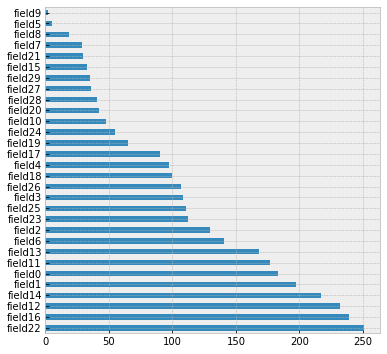

In [0]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')
print(feat_importances.nlargest(30).index)

In [0]:
X, y = prepare_data( df_train)

from sklearn.utils import all_estimators

def_params = {
    'random_state': RS,
    'n_jobs': -1
}

estimators = all_estimators(type_filter='classifier')
for name, class_ in estimators:
  print(class_)
  #try:
  #  model = estimate(X, y, class_());
  #except:
  #  pass



## Recursive Feature Elimination

In [89]:
from sklearn.feature_selection import RFECV

X_ = add_aggregates(df_train)
X, y = prepare_data( X_ ) #goosh

rfe = RFECV(XGBClassifier(**get_best_params_xgbc()), cv=KFold(n_splits=5, shuffle=True, random_state=RS), 
            scoring='roc_auc', n_jobs=-1, verbose=10)

rfe.fit(X, y.values.ravel())
print('remove: ', X.iloc[:, ~rfe.support_].columns)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
F

In [104]:
np.max(rfe.grid_scores_)
#rfe.support_

0.70473012466737

In [92]:
X.iloc[:, rfe.support_].columns

Index(['field0', 'field1', 'field4', 'field6', 'field7', 'field10', 'field12',
       'field14', 'field16', 'field21', 'field25', 'field28', 'field0_std',
       'field0_sum', 'field0_max', 'field0_mean', 'field1_std', 'field1_sum',
       'field1_mean', 'field2_std', 'field2_sum', 'field2_max', 'field3_std',
       'field5_mean', 'field6_sum', 'field6_max', 'field6_mean',
       'field10_mean', 'field11_std', 'field12_std', 'field12_max',
       'field12_min', 'field12_mean', 'field13_std', 'field14_std',
       'field14_max', 'field14_mean', 'field15_std', 'field15_mean',
       'field16_std', 'field16_sum', 'field16_max', 'field16_min',
       'field16_mean', 'field17_max', 'field18_sum', 'field19_mean',
       'field21_std', 'field21_mean', 'field22_std', 'field22_min',
       'field23_std', 'field26_std', 'field26_sum', 'field26_max',
       'field26_mean', 'field27_std', 'field27_mean', 'field28_mean',
       'field29_mean'],
      dtype='object')

## SequentialFeatureSelector

In [0]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

X, y = prepare_data( df_train )
print('baseline')
model = estimate(X_, y, XGBClassifier(**get_best_params_xgbc()), plot=False)
if hasattr(model, 'best_ntree_limit'): print(scores.append(model.best_score))
if hasattr(model, 'best_score_'): print(model.best_score_['valid_0']['auc'])

sfs1 = SFS(XGBClassifier(**get_best_params_xgbc()), 
           k_features='best', 
           forward=True, 
           floating=False, 
           verbose=2,
           #scoring='log_loss', 
           scoring='roc_auc', 
           cv=3,
           n_jobs=-1)

sfs1 = sfs1.fit(X, y.values.ravel())

print(sfs1.k_score_)
print(sfs1.k_feature_names_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.0min finished

[2019-12-10 13:51:36] Features: 1/30 -- score: 0.6235264130352441[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


## 5-KFold estimation

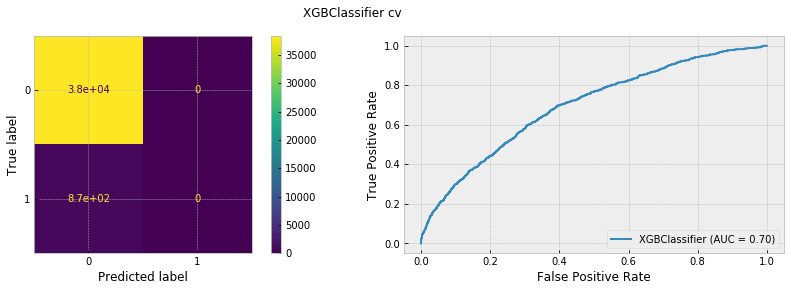

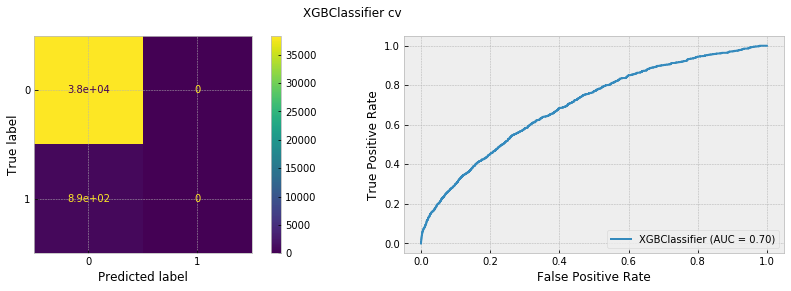

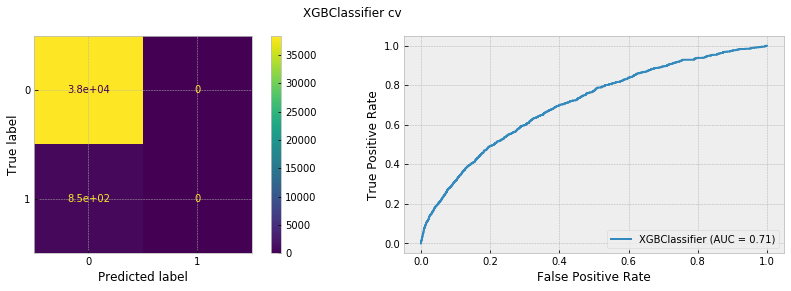

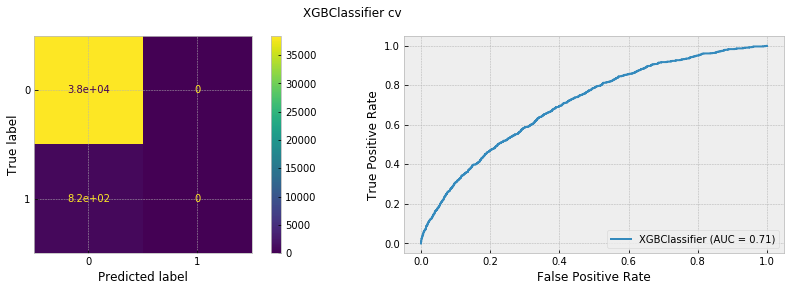

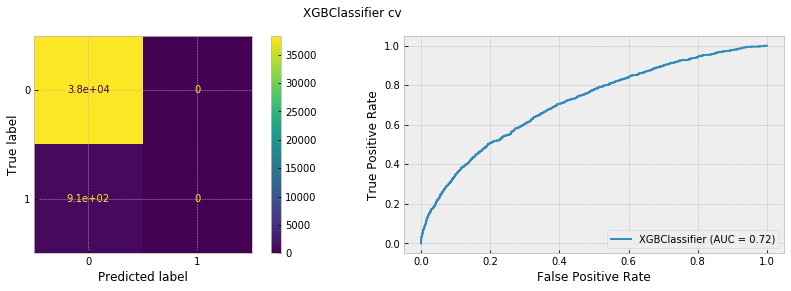

XGBClassifier cv: 0.7054 ± 0.0066.


'\npoly = polies[np.argmax(scores)]\nX = add_polynomial_inner(X, poly)\n'

In [105]:
X_ = df_train
# baseline: 0.6909 ± 0.0085.
#X_ = X_.drop(['field5', 'field11', 'field23', 'field29'], axis=1) # 0.6902 ± 0.0081.
X_ = add_aggregates(X_)
X, y = prepare_data(X_)

X = X[['field0', 'field1', 'field4', 'field6', 'field7', 'field10', 'field12',
       'field14', 'field16', 'field21', 'field25', 'field28', 'field0_std',
       'field0_sum', 'field0_max', 'field0_mean', 'field1_std', 'field1_sum',
       'field1_mean', 'field2_std', 'field2_sum', 'field2_max', 'field3_std',
       'field5_mean', 'field6_sum', 'field6_max', 'field6_mean',
       'field10_mean', 'field11_std', 'field12_std', 'field12_max',
       'field12_min', 'field12_mean', 'field13_std', 'field14_std',
       'field14_max', 'field14_mean', 'field15_std', 'field15_mean',
       'field16_std', 'field16_sum', 'field16_max', 'field16_min',
       'field16_mean', 'field17_max', 'field18_sum', 'field19_mean',
       'field21_std', 'field21_mean', 'field22_std', 'field22_min',
       'field23_std', 'field26_std', 'field26_sum', 'field26_max',
       'field26_mean', 'field27_std', 'field27_mean', 'field28_mean',
       'field29_mean']]

scores, models, neighbs, polies = fit_estimate(X, y,
        #lambda: skl.ensemble.BaggingClassifier(XGBClassifier(**get_best_params()), n_estimators=10, random_state=RS, oob_score=True),
        lambda: XGBClassifier(**get_best_params_xgbc()), 
        #lambda: LGBMClassifier(**get_best_params_lgbm()),
        n_folds=5, degree=0, n_neighbors=0)
model = models[np.argmax(scores)]

'''
neigh = neighbs[np.argmax(scores)]
X = add_neughbors_inner(X, neigh)
'''
'''
poly = polies[np.argmax(scores)]
X = add_polynomial_inner(X, poly)
'''
#[1/5][2/5][3/5][4/5][5/5]XGBClassifier CV: 0.6876 ± 0.0086. params fine tuning, -f0
#[1/5][2/5][3/5][4/5][5/5]XGBClassifier CV: 0.6881 ± 0.0090. params fine tuning, -f0, f28 +5 neigh
#[1/5][2/5][3/5][4/5][5/5]XGBClassifier cv: 0.6885 ± 0.0078. polinomial, 0 neigh
#[1/5][2/5][3/5][4/5][5/5]XGBClassifier cv: 0.6895 ± 0.0111. polimonial, 5 neigh
#[1/5][2/5][3/5][4/5][5/5]XGBClassifier cv: 0.6895 ± 0.0092. -1/2 field21, 0 neigh
# XGBClassifier cv: 0.6907 ± 0.0085. 0 neigh, 

In [0]:
a = df_train.groupby('userid', as_index=False).count()
a = a[a.field0 > 1]
a = df_train.loc[df_train.userid.isin([*a.userid])]
a.goal1.hist()

In [0]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
17,field7_field16,0.224827
22,field21_0,0.115388
34,field10_0,0.101748
19,field12_field16,0.088139
21,field12_field25,0.080946
...,...,...
35,field10_1,0.000000
32,field9_3,0.000000
51,field19_8,0.000000
50,field19_7,0.000000


In [0]:
import shap
%time shap_values = shap.TreeExplainer(model).shap_values(X)
shap.summary_plot(shap_values, X)

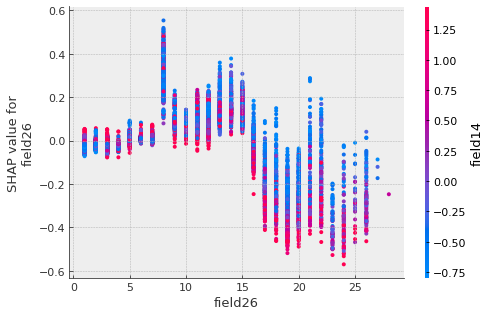

In [0]:
shap.dependence_plot("field26", shap_values, X)

In [0]:
from sklearn.manifold import TSNE

plt_data = X.head(10000)

tsne = TSNE(random_state=0)
tsne_rep = tsne.fit_transform(plt_data)

#plt.scatter(tsne_rep[:,0], tsne_rep[:,1], c=plt_data['target'].map({0:'blue', 1:'red'}), alpha=.5)
plt.scatter(tsne_rep[y==0,0], tsne_rep[y==0,1], alpha=.5, c='blue', label='norm')
plt.scatter(tsne_rep[y==1,0], tsne_rep[y==1,1], alpha=.5, c='orange', label='refunded')
plt.legend()

In [0]:
X, y = prepare_data( df_train )

import seaborn as sns
Y = X.head(2000)
Y['goal1'] = y.values.ravel()
sns.pairplot(Y, diag_kind="kde")

## SearchGridCV

In [0]:
X, y = prepare_data( df_train )

params = { 
  'metric': ['rmse', 'rmsle', 'mae', 'logloss', 'error', 'error@t', 'merror', 
                  'mlogloss', 'auc', 'aucpr', 'ndcg', 'map', 'ndcg@n', 'ndcg@n', 
                  'ndcg-', 'map-', 'ndcg@n-', 'ndcg@n-']

  }

gs = GridSearchCV(LGBMClassifier(**get_best_params_lgbm()),
                  params, 
                  cv=KFold( n_splits = 5, shuffle=True, random_state=RS),
                  verbose=10, 
                  n_jobs=-1,
                  scoring='roc_auc')
gs.fit(X, y)
print( gs.best_params_ )
print( gs.best_score_ )

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

{'metric': 'rmse'}
0.6785321104213122


In [0]:
X, y = prepare_data( df_train )

X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=RS, shuffle=True)

model = XGBClassifier(**get_best_params()).fit(X, y.values.ravel())

plot_permutation_importance(model, X_train, y_train, X_cv, y_cv)

estimate(X, y, model);

In [0]:
X.columns[sorted_idx]

Index(['field5', 'field19', 'field7', 'field2', 'field15', 'field8', 'field20',
       'field0', 'field16', 'field4', 'field9', 'field17', 'field18', 'field1',
       'field14', 'field11', 'field12', 'field6', 'field21', 'field13',
       'field3', 'field10'],
      dtype='object')

## RandomizedSearchCV

In [0]:
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt   
import sklearn.ensemble

X, y = prepare_data(df_train)

params = {'base_score': sp_randFloat(),
 'colsample_bylevel': sp_randFloat(),
 'colsample_bynode': sp_randFloat(),
 'colsample_bytree': sp_randFloat(),
 'gamma': sp_randInt(0, 100),
 'learning_rate': sp_randFloat(),
 'max_delta_step': sp_randInt(0, 100),
 'max_depth': sp_randInt(2, 10),
 'min_child_weight': sp_randFloat(),
 'n_estimators': sp_randInt(10, 500),
 'reg_alpha': sp_randFloat(),
 'reg_lambda': sp_randFloat(),
 'scale_pos_weight': sp_randFloat(),
 'subsample': sp_randFloat(),
 }

params = {
  'colsample_bytree': sp_randFloat(),
  'learning_rate': sp_randFloat(),
  'max_depth': sp_randInt(2, 50),
  'min_child_samples': sp_randInt(2, 50),
  'min_child_weight': sp_randFloat(),
  'min_split_gain': sp_randFloat(),
  'n_estimators': sp_randInt(10, 500),
  'num_leaves': sp_randInt(1, 200),
  'reg_alpha': sp_randFloat(),
  'reg_lambda': sp_randFloat(),
  'subsample': sp_randFloat(),
  'subsample_freq': sp_randInt(0, 50),
  }

clf = LGBMClassifier(**get_best_params_lgbm())

rs = RandomizedSearchCV(clf, 
                        param_distributions=params, 
                        cv=2, 
                        verbose=1, 
                        n_iter=1000, 
                        scoring='roc_auc',
                        n_jobs=-1)
rs.fit(X, y.values.ravel())
print( rs.best_params_ )
print( rs.best_score_ )
#{'base_score': 0.6644410991187997, 'colsample_bylevel': 0.6059678409651669, 'colsample_bynode': 0.17400982470452497, 'colsample_bytree': 0.6647085043362304, 'gamma': 0.01605629494332772, 'learning_rate': 0.09143541671068811, 'max_delta_step': 0.9405103527865268, 'max_depth': 9, 'min_child_weight': 0.23677205024963843, 'n_estimators': 116, 'n_jobs': -1, 'random_state': 77, 'reg_alpha': 0.983017349002685, 'reg_lambda': 0.7338821091963531, 'scale_pos_weight': 0.1314841497459578, 'seed': 7, 'subsample': 0.610130474493417}
#{'base_score': 0.0006763272285300603, 'colsample_bylevel': 0.9131040645300111, 'colsample_bynode': 0.6217260824900458, 'colsample_bytree': 0.498105896239323, 'gamma': 0.7503808382193502, 'learning_rate': 0.5233450726284934, 'max_delta_step': 0.2189376337324893, 'max_depth': 8, 'min_child_weight': 0.9084424403935606, 'n_estimators': 177, 'n_jobs': -1, 'random_state': 77, 'reg_alpha': 0.8494551200058984, 'reg_lambda': 0.8606428319131949, 'scale_pos_weight': 0.11685893701548733, 'seed': 6, 'subsample': 0.6828797818811899}
#{'base_score': 0.9883241431311958, 'colsample_bylevel': 0.8954745282201794, 'colsample_bynode': 0.9053728787963939, 'colsample_bytree': 0.37737648074076036, 'gamma': 51, 'learning_rate': 0.06869149756603576, 'max_delta_step': 22, 'max_depth': 4, 'min_child_weight': 0.8940873051252118, 'n_estimators': 298, 'reg_alpha': 0.2901487558842103, 'reg_lambda': 0.7240220329478356, 'scale_pos_weight': 0.11997115325466545, 'subsample': 0.699092108437742}

Fitting 2 folds for each of 1000 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 54.6min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 77.5min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 85.0min finished


{'colsample_bytree': 0.3811304824216669, 'learning_rate': 0.016659893432998896, 'max_depth': 20, 'min_child_samples': 12, 'min_child_weight': 0.0036350360157623163, 'min_split_gain': 0.9619961904304549, 'n_estimators': 203, 'num_leaves': 32, 'reg_alpha': 0.8022751137716411, 'reg_lambda': 0.8186913351852023, 'subsample': 0.5967826661188248, 'subsample_freq': 14}
0.680844468513861


## Submit the result

In [0]:
model.best_ntree_limit

290

In [107]:
X_ = df_test
X_ = add_aggregates(X_)

X_test, _ = prepare_data( X_ )

X_test = X_test[['field0', 'field1', 'field4', 'field6', 'field7', 'field10', 'field12',
       'field14', 'field16', 'field21', 'field25', 'field28', 'field0_std',
       'field0_sum', 'field0_max', 'field0_mean', 'field1_std', 'field1_sum',
       'field1_mean', 'field2_std', 'field2_sum', 'field2_max', 'field3_std',
       'field5_mean', 'field6_sum', 'field6_max', 'field6_mean',
       'field10_mean', 'field11_std', 'field12_std', 'field12_max',
       'field12_min', 'field12_mean', 'field13_std', 'field14_std',
       'field14_max', 'field14_mean', 'field15_std', 'field15_mean',
       'field16_std', 'field16_sum', 'field16_max', 'field16_min',
       'field16_mean', 'field17_max', 'field18_sum', 'field19_mean',
       'field21_std', 'field21_mean', 'field22_std', 'field22_min',
       'field23_std', 'field26_std', 'field26_sum', 'field26_max',
       'field26_mean', 'field27_std', 'field27_mean', 'field28_mean',
       'field29_mean']]

if hasattr(model, 'best_ntree_limit'):
  print(0)
  proba = model.predict_proba(X_test, ntree_limit=model.best_ntree_limit)
else:
  print(1)
  proba = model.predict_proba(X_test)

pd.DataFrame(proba[:, 1], columns=['proba'], index=X_test.index).to_csv('sub1.csv')

0


In [108]:
!zip sub1.csv.zip sub1.csv

  adding: sub1.csv (deflated 64%)


In [0]:
!pip3 install -q eli5
import eli5
from eli5.sklearn import PermutationImportance

In [0]:
!pip3 install -q catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 63.6MB 124kB/s 


In [0]:
!pip install -q shap

In [0]:
!pip install -q scikit-plot
